<a href="https://colab.research.google.com/github/Yoon0527/AI_study/blob/main/handson_ml2_ch7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

# 반달 모양 데이터셋 moons 생성
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)

# 데이터셋 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [6]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [7]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


* 배깅: 훈련 세트에서 중복을 허용하여 샘플링하는 방식
* 페이스팅: 중복을 허용하지 않는 방식
전반적으로 배깅이 더 나은 모델을 만들기 때문에 일반적으로 더 선호한다.(중복을 허용하기 때문에?) cpu 파워와 시간적 여유가 있다면 교차 검증으로 배깅과 페이스팅을 모두 평가해서 더 나은 쪽을 선택하는 것이 좋다.

1. 부트스트래핑은 각 예측기가 학습하는 서브셋(데이터셋을 나눈 거)에 다양성을 증가 시킨다.(bootstrap=True로 두면 중복을 허용하는 건데 그럼 다양성이 감소하지 않나?) -> 해결

2. 따라서 배깅이 페이스팅보다 편향이 조금 더 높다.(편향이 높다는 건 예측값들과 정답이 멀리 떨어져 있다는 뜻)

3. 하지만 다양성을 추가한다는 것은 예측기들의 상관관계를 줄이므로 앙상블의 분산을 감소시킨다.(분산이 높다는 건 예측값들끼리 대체로 흩어져있는 건데, 분산을 감소시킨다는 건 예측값들끼리 멀리 떨어진 정도를 줄인다는 뜻인 듯)

> 예를 들어 A, B, C, D, E 다섯 개로 이루어진 데이터셋을 서브셋으로 나눌 때, bootstrap을 False로 줘서 중복을 허용하지 않으면 생성할 수 있는 서브셋에 한계가 있음(경우의 수가 줄어든다). 이 때문에 bootstrap을 True로 두고 중복을 허용하여 서브셋의 다양성을 확보한다는 의미인 듯.
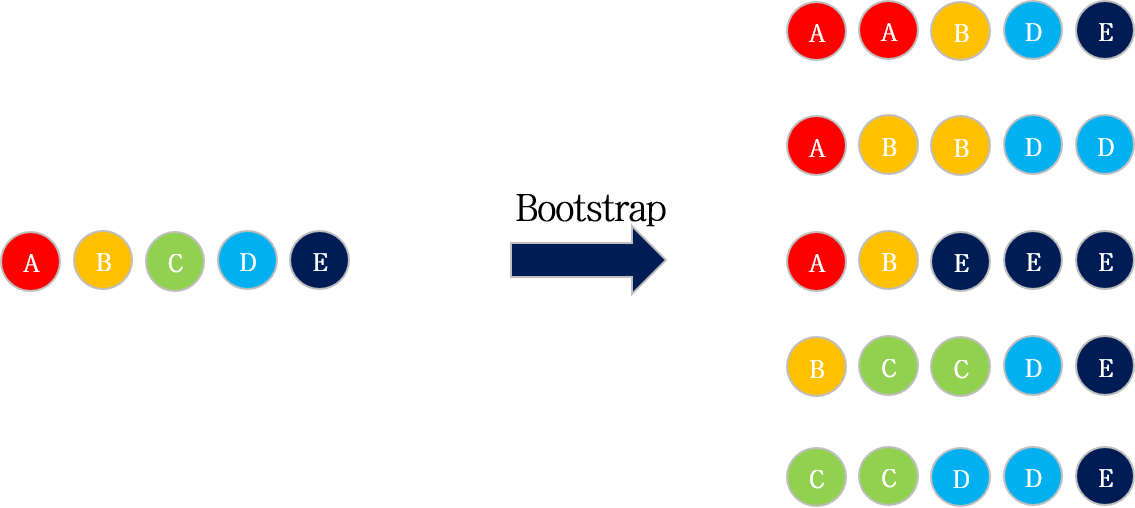
(https://tyami.github.io/machine%20learning/ensemble-2-bagging-random-forest/) 

여기서 이해가 안되는 건 다양성의 증가가 편향이 높은 것과 무슨 관계가 있는지? 

In [8]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# n_estimators: 앙상블에 사용할 분류기의 수
# max_samples: 무작위로 뽑을 샘플의 수(0~1 사이의 수로 지정하면 비율이 되어서 훈련 세트에 곱한 값만큼 샘플링)
# bootstrap: True(중복 허용), False(중복 X)
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

## 7.2.2 oob 평가

배깅을 사용하면 어떤 샘플은 한 예측기를 위해 여러 번 샘플링 되고 어떤 것은 전혀 선택되지 않을 수 있다. BaggingClassifier는 기본값으로 중복을 허용하여 훈련 세트의 크기 만큼인 m개 샘플을 선택하는데, 이는 평균적으로 각 예측기에 훈련 샘플의 63% 정도만 샘플링 되는 것을 의미한다.

선택되지 않은 훈련 샘플의 나머지 37%를 oob(out of bag) 샘플이라고 함. **예측기마다 남겨진 37%는 모두 다르다.**

이 oob 샘플을 검증 셋으로 사용함. 앙상블의 평가는 각 예측기의 oob 평가를 평균해서 얻는다.
> 사이킷런에서 BaggingClassifier를 만들 때 oob_score를 True로 지정해 자동으로 oob 평가를 수행한다.

In [9]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

In [10]:
bag_clf.oob_decision_function_

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.7173913 , 0.2826087 ],
       [0.85026738, 0.14973262],
       [0.97222222, 0.02777778],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97837838, 0.02162162],
       [0.94642857, 0.05357143],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.39473684, 0.60526316],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.

In [11]:
# 정확도 확인
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

In [13]:
# oob 평가
bag_clf.oob_decision_function_

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.7173913 , 0.2826087 ],
       [0.85026738, 0.14973262],
       [0.97222222, 0.02777778],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97837838, 0.02162162],
       [0.94642857, 0.05357143],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.39473684, 0.60526316],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.

## 7.3 랜덤 패치와 랜덤 서브스페이스
* 랜덤 패치: 훈련 특성과 샘플을 모두 샘플링하는 것
* 랜덤 서브스페이스: 훈련 샘플을 모두 사용(bootstrap=False, max_samples=1.0), 특성은 샘플링(bootstrap_features=True로 지정하고 and/or max_features는 1.0보다 작게 설정) 하는 것

특성 샘플링은 더 다양한 예측기를 만들며 편향을 늘리는 대신 분산을 낮춘다.

## 랜덤 포레스트

In [14]:
# 랜덤 포레스트 분류기를 여러 CPU 코어에서 훈련시키는 코드

from sklearn.ensemble import RandomForestClassifier

# max_leaf_nodes: 최대 리프노드의 개수 지정
# n_jobs: -1로 주면 시스템에 있는 CPU 코어 수를 모두 사용해 학습
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [ ]:
# BaggingClassifier를 사용해 RandomForestClassifier와 유사하게 만든 코드

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)

* max_features = "sqrt" 
  * https://scikit-learn.org/stable/modules/ensemble.html#forest
  * 분류(Classification)의 경우 sqrt(n_features)로 둔다? 왜?
  * 회귀(Regression)의 경우 max_features = n_features로 둔다

### 7.4.1 엑스트라 트리
트리를 만들 때 각 노드는 무작위로 특성의 서브셋을 만들어 분할에 사용한다. 트리를 더욱 무작위하게 만들기 위해 최적의 임계값을 찾는 대신 후보 특성을 사용해 무작위로 분할한 다음 그 중에서 최상의 분할을 선택한다.

이처럼 극단적으로 무작위한 트리의 랜덤 포레스트를 익스트림 랜덤 트리 앙상블, 또는 엑스트라 트리라고 부른다. 여기서도 편향이 늘어나지만 분산을 낮추게 된다.
> 모든 노드에서 특성 마다 최적의 임곗값을 찾는 것이 트리 알고리즘에서 가장 시간이 많이 소요되는 작업 중 하나이므로 일반적인 랜덤 포레스트보다 엑스트라 트리가 훨씬 빠르다.

> RandomForestClassifier가 ExtraTreesClassifier보다 더 나은지 나쁜지는 둘 다 시도해보는 것이 알 수 있는 유일한 방법

위 둘의 차이는 RandomForestClassifier는 트리를 무작위하게 만들기 위해 최적의 임계값을 찾지만 엑스트라 트리는 후보 특성을 사용해 무작위로 분할 다음 그 중에서 최상의 분할을 선택한다.

### 7.4.2 특성 중요도
랜덤 포레스트는 특성의 상대적 중요도를 측정하기 쉽다는 것임.(무작위성이 주입된 랜덤 포레스트는 거의 모든 특성에 대해 평가할 기회를 가진다)

사이킷런은 훈련이 끝난 뒤 특성마다 자동으로 이 점수를 계산하고 중요도의 전체 합이 1이 되도록 결괏값을 정규화한다.

In [15]:
# iris 데이터셋에 RandomForestClassifier를 훈련시키고 각 특성의 중요도를 출력한다.
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


랜덤 포레스트는 특성을 선택해야할 때 어떤 특성이 중요한지 빠르게 확인할 수 있어 매우 편리함.

## 7.5 부스팅
약한 학습기를 여러 개 연결해서 강한 학습기를 만드는 앙상블 기법. 앞의 모델을 보완해나가면서 일련의 예측기를 학습시키는 것인데, 가장 인기있는 부스팅 방법에는 **에이다부스트(AdaBoost, adptive boosting의 줄임말)**와 **그레디언트 부스팅(gradient boosting)**이 있다.


### 7.5.1 에이다 부스트
이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이는 것이다. 이러면 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰지게 된다.

1. 알고리즘이 기반이 되는 첫 번째 분류기(예를 들어 결정 트리)를 훈련 세트에서 훈련시키고 예측을 만든다.
2. 알고리즘이 잘못 분류된 훈련 샘플의 가중치를 상대적으로 높인다.
3. 두 번째 분류기는 업데이트된 가중치를 사용해 훈련 세트에서 훈련하고 다시 예측을 만든다.
4. 다시 가중치를 업데이트하는 식으로 반복

In [16]:
# 에이다 부스트
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

### 7.5.2 그레디언트 부스팅
에이다부스트처럼 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가하지만 에이다부스트처럼 반복마다 샘플의 가중치를 수정하는 대신 이전 예측기가 만든 **잔여 오차(residual error)**에 새로운 예측기를 학습시킨다.